# Entraînement d'un réseau seq2seq sur des séries temporelles

L'exercice est d'abord d'entraîner un tel réseau sur un tout petit dataset d'un signal sinusoidal, puis de tenter de prédire des signaux de plus en plus complexes. 

**Pour décider de l'exercice à faire, changer la valeur `exercice` suivante:**


In [1]:
# Valeurs possibles : 1, 2, ou 3. 
exercice = 1

# En théorie, pour l'exercice 1 et 2, il est possible de créer une ligne vraiment presque parfaite. 
# Pour l'exercice 3, le problème est beaucoup plus difficile. 

Je recommande de commencer par l'exercice 1 et d'y aller graduellement. Dans chaque cas, nous avons plusieurs séries temporelles différentes en parallèle à prédire: notre réseau de neurones est multidimensionnel car il prédit plusieurs séries à la fois. 

In [2]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tempfile
import math


In [3]:

# Neural net's parameters
seq_length = 15  # Inputs and outputs are sequences of same lenght
batch_size = 1  # Keeping it simple for now

# Each unit in the sequence is a float32 vector of lenght 10:
# Same dimension sizes just for simplicity now
output_dim = hidden_dim = input_dim = 10
layers_stacked_count = 2

# Optmizer: 
learning_rate = 0.007  # Small lr to avoid problem
nb_iters = 300  # Crank up the iters in consequence
lr_decay = 0.92  # 0.9 default
momentum = 0.5  # 0.0 default
lambda_l2_reg = 0.003


In [4]:

tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()


In [5]:

with tf.variable_scope('Seq2seq'):

    # Entrées dans l'encodeur
    enc_inp = [tf.placeholder(tf.float32, shape=(None, input_dim),
                              name="inp%i" % t)
               for t in range(seq_length)]

    # Sorties attendues du décodeur
    expected_sparse_output = [tf.placeholder(tf.float32, shape=(None, output_dim),
                            name="expected_sparse_output%i" % t)
              for t in range(seq_length)]
    
    # Donner un symbole "GO" au décodeur
    dec_inp = [tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO")] + enc_inp[:-1]

    # Créer un nombre `layers_stacked_count` de RNN empilés
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            # GRU est similaire au LSTM, 
            # mais pas exactement pareil à l'intérieur: 
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )
    
    # Une dernière transformation linéaire à la sortie: 
    output_scale_factor = tf.Variable(3.0, name="Output_ScaleFactor")
    output_bias = tf.Variable(-1.5, name="Output_Bias")
    dec_outputs = [ output_scale_factor * tf.nn.sigmoid(output) + output_bias for output in dec_outputs]


In [6]:

# Training loss and optimizer

with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(dec_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        
    # L2 regularization 
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
            
    loss = output_loss + lambda_l2_reg * reg_loss

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)


In [7]:

def generate_x_y_data(isTest=False, exercise=1):
    """
    Simply returns data of shape: 
        (seq_lenght, batch_size, output_dim)
    
    X is a sine of domain 0.0*pi to 1.5*pi
    Y is a sine of domain 1.5*pi to 3.0*pi
    
    To temporarily deal with the number of dimensions 
    """
    # Create the sine in x and it's continuation in y
    x = np.sin(np.linspace(0.0*math.pi, 1.5*math.pi, seq_length))
    y = np.sin(np.linspace(1.5*math.pi, 3.0*math.pi, seq_length))
    
    # Clone the sine for every input_dim. 
    # Normaly those dims would containt different signals 
    # happening at the same time of a single timestep of 
    # a single training example, such as other features of 
    # the signal such as various moving averages 
    x = np.array([x for i in range(input_dim)])
    y = np.array([y for i in range(output_dim)])
    x, y = x.T, y.T
    
    x = np.array([x]*batch_size) # simple for now: batch_size of 1
    y = np.array([y]*batch_size)
    # shape: (batch_size, seq_lenght, output_dim)
    x = np.array(x).transpose((1, 0, 2))
    y = np.array(y).transpose((1, 0, 2))
    # shape: (seq_lenght, batch_size, output_dim)
    
    # print "X_SHAPE: " + str(x.shape)
    return x, y

def train_batch(batch_size):
    """
    Training step: we optimize for every outputs Y at once, 
    feeding all inputs X
    
    I do not know yet how to deal with 
    the enc_inp tensor declared earlier
    """
    X, Y = generate_x_y_data()

    feed_dict = {
        enc_inp[t]: X[t] for t in range(seq_length)
    }
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(seq_length)})

    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t


# Train
train_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    loss_t = train_batch(batch_size)
    train_losses.append(loss_t)
    if t % 10 == 0: 
        print "Step {}/{}, loss: {}".format(t, nb_iters, loss_t)

print "Final loss: {}".format(loss_t)


Step 0/300, loss: 38.8384513855
Step 10/300, loss: 19.5592193604
Step 20/300, loss: 6.61626577377
Step 30/300, loss: 3.06511211395
Step 40/300, loss: 1.82426404953
Step 50/300, loss: 1.22619497776
Step 60/300, loss: 0.913633704185
Step 70/300, loss: 1.12009239197
Step 80/300, loss: 0.630489826202
Step 90/300, loss: 0.55859375
Step 100/300, loss: 0.500613033772
Step 110/300, loss: 0.73316848278
Step 120/300, loss: 0.399022102356
Step 130/300, loss: 0.366254329681
Step 140/300, loss: 0.32592600584
Step 150/300, loss: 0.310336828232
Step 160/300, loss: 0.308530062437
Step 170/300, loss: 0.237408235669
Step 180/300, loss: 0.48581930995
Step 190/300, loss: 0.224515855312
Step 200/300, loss: 0.184582442045
Step 210/300, loss: 0.201388195157
Step 220/300, loss: 0.376052886248
Step 230/300, loss: 0.156198993325
Step 240/300, loss: 0.169976904988
Step 250/300, loss: 0.226530894637
Step 260/300, loss: 0.27032494545
Step 270/300, loss: 0.135500147939
Step 280/300, loss: 0.12970739603
Step 290/300

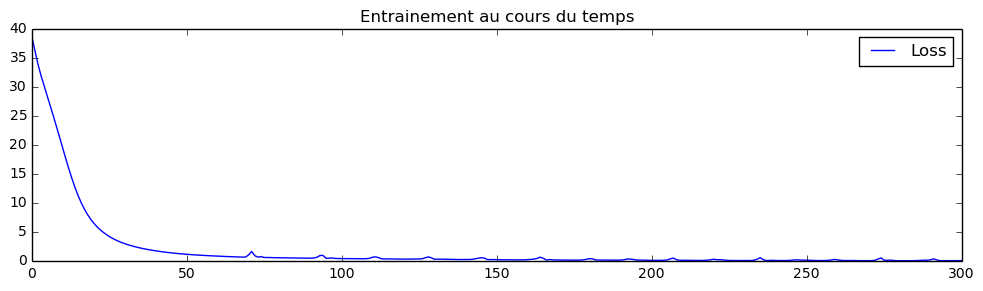

In [8]:
plt.figure(figsize=(12, 3))
plt.plot(train_losses, label="Loss")
plt.title("Entrainement au cours du temps")
plt.legend(loc='best')
plt.show()

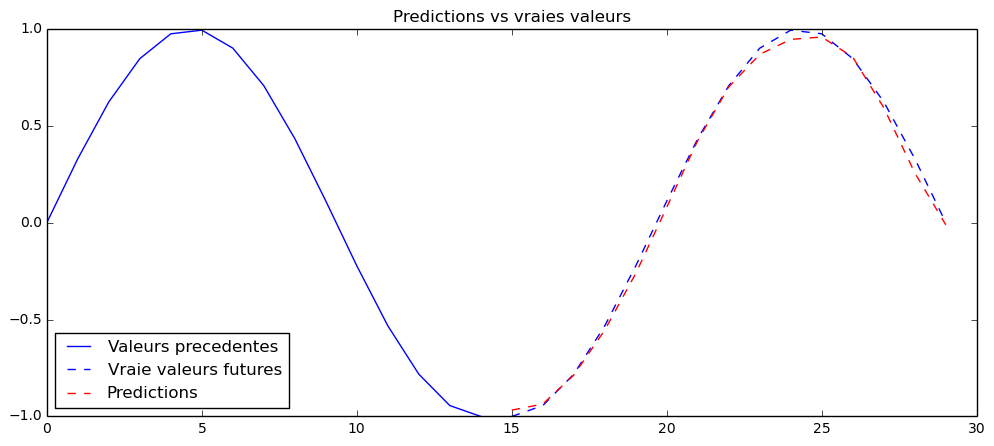

In [9]:
# Test the training
X, Y = generate_x_y_data()
feed_dict = {
    enc_inp[t]: X[t] for t in range(seq_length)
}
outputs = sess.run([dec_outputs], feed_dict)

past = X[:,0,0]
expected = Y[:,0,0]
pred = np.array(outputs[0])[:,0,0]

plt.figure(figsize=(12, 5))
plt.plot(list(range(len(past))), past, "b", label="Valeurs precedentes")
plt.plot(range(len(past), len(expected)+len(past)), expected, "--b", label="Vraie valeurs futures")
plt.plot(range(len(past), len(pred)+len(past)), pred, "--r", label="Predictions")
# plt.plot(pred)
plt.legend(loc='best')
plt.title("Predictions vs vraies valeurs")
plt.show()

In [10]:
for i in tf.trainable_variables():
    print i.name

Seq2seq/basic_rnn_seq2seq/RNN/MultiRNNCell/Cell0/GRUCell/Gates/Linear/Matrix:0
Seq2seq/basic_rnn_seq2seq/RNN/MultiRNNCell/Cell0/GRUCell/Gates/Linear/Bias:0
Seq2seq/basic_rnn_seq2seq/RNN/MultiRNNCell/Cell0/GRUCell/Candidate/Linear/Matrix:0
Seq2seq/basic_rnn_seq2seq/RNN/MultiRNNCell/Cell0/GRUCell/Candidate/Linear/Bias:0
Seq2seq/basic_rnn_seq2seq/RNN/MultiRNNCell/Cell1/GRUCell/Gates/Linear/Matrix:0
Seq2seq/basic_rnn_seq2seq/RNN/MultiRNNCell/Cell1/GRUCell/Gates/Linear/Bias:0
Seq2seq/basic_rnn_seq2seq/RNN/MultiRNNCell/Cell1/GRUCell/Candidate/Linear/Matrix:0
Seq2seq/basic_rnn_seq2seq/RNN/MultiRNNCell/Cell1/GRUCell/Candidate/Linear/Bias:0
Seq2seq/basic_rnn_seq2seq/rnn_decoder/MultiRNNCell/Cell0/GRUCell/Gates/Linear/Matrix:0
Seq2seq/basic_rnn_seq2seq/rnn_decoder/MultiRNNCell/Cell0/GRUCell/Gates/Linear/Bias:0
Seq2seq/basic_rnn_seq2seq/rnn_decoder/MultiRNNCell/Cell0/GRUCell/Candidate/Linear/Matrix:0
Seq2seq/basic_rnn_seq2seq/rnn_decoder/MultiRNNCell/Cell0/GRUCell/Candidate/Linear/Bias:0
Seq2seq/